# Solving a one-asset HANK model in sequence space
In this notebook we show how to
1. [Set up a heterogenous agent block](#1-hetblock)
2. [Solve for a steady state with multiple calibration targets](#2-calibration)
3. [Compute the Jacobian almost automatically via helper functions](#3-jacobian)
4. [Compute linearized impulse responses](#4-linear)
5. [Compute nonlinear impulse responses](#5-nonlinear)
6. [Check local determinacy](#6-determinacy)

This notebook accompanies work in progress by Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

## Model description
The model is a HA version of the textbook New Keynesian model. Technology is linear in labor, prices are sticky á la Rotemberg, and monetary policy follows a Taylor rule. For a detailed description of the model, please see the slides. As a reminder, the model can be summarized in sequence form as

$$
\textbf{H}_t(\textbf{Y}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t L_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t L_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{N}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

where the endogenous variables are $\textbf{Y} = (Y, L, r, w, d, \pi, \tau, i)$ and the exogenous variables are $\textbf{Z}=(r^*, Z)$. 

The asset demand and labor supply functions $\{\mathcal{A}, \mathcal{L}\}$ follow from the household block with Bellman equation

$$
\begin{align}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \sum_{e'}V_{t+1}(e', a) \mathcal{P}(e,e') \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t e n - \tau_t \bar{\tau}(e) + d_t \bar{d}(e)
\\
a &\geq 0
\end{align}
$$

where $\bar\tau(e)$ and $\bar d(e)$ are skill-specific incidence rules for taxes and dividends. 

We can think of the model as a directed acyclical graph (DAG) with **3 endogenous inputs**  

![Directed Acyclical Graph](figures/hank_dag.png) 

and write it as an implicit function

$$
H(\pi, Y, w; \epsilon, Z) = 0.
$$

## 0 Import packages
The first two are standard python packages, the rest contain code we wrote for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
from het_block import het
import simple_block as sim
from simple_block import simple
import jacobian as jac
import nonlinear
import hank

<a id="1-hetblock"></a>

## 1 Set up heterogeneous-agent block
The main task here is to write a **backward iteration function** that represents the Bellman equation. This has to be a single step of an iterative solution method such as value function iteration. For the standard income fluctuation problem with endogenous labor supply we're dealing with here, the endogenous gridpoint method of [Carroll (2006)](https://www.sciencedirect.com/science/article/pii/S0165176505003368) is the best practice.

Solving the endogenous-labor problem via EGM is standard but somewhat tedious and so the details are left to ``hank.py``. Given the backward iteration function, it is straighforward to construct a `HetBlock` instance. As its name suggests, HetBlock is a general class of heterogeneous-agent blocks that comes with useful methods, such as solving for steady-state policy functions by iteration and computing Jacobians. In this notebook, we are going to cover the most important of these.

**NEED TO DISCUSS THIS HERE**

In [2]:
def transfers(pi_e, Div, Tax, e_grid, div_rule=None, tax_rule=None):
    # need input pi_e, stationary distribution of agents
    if tax_rule is None:
        tax_rule = e_grid
    if div_rule is None:
        div_rule = e_grid
    assert len(tax_rule) == len(div_rule) == len(e_grid), 'Incidence rules are inconsistent with income grid.'
    
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    
    T = div - tax
    return T

In [3]:
household = hank.household.attach_hetinput(transfers)

<a id="2-calibration"></a>

## 2 Calibrating the steady state
Next, we embed this HA block in general equilibrium. We calibrate the discount factor $\beta$ and disutility of labor $\varphi$ to hit quarterly interest rate $r=0.005$ (approx. 2% annually) and total effective labor $L=1.$

This is a two-dimensional rootfinding problem that we solve by Broyden's method which we implemented in ``utils.py``. it takes a function $f: \mathbb{R}^n \to \mathbb{R}^n$ and an initial guess for its roots, $x_0 \in \mathbb{R}^n.$ The user can  define a set of invalid inputs from which the solver backtracks. This useful feature is the main reason for implementing our own routine.

The calibration has two substantive steps. First, express analytically all variables that don't depend on $(\beta, \varphi).$ Second, construct the residual function that takes the current guesses $(\beta, \varphi)$ and maps them into deviations from he calibration targets. This just requires an evaluation of the household block. The rootfinder does the rest. 

Although additional efficiency gains would be possible here (for instance, by updating our initial guesses for policy and distribution along the way), we will not implement them, since they are not our focus here.

In [4]:
def hank_ss(beta_guess=0.986, vphi_guess=0.8, r=0.005, eis=0.5, frisch=0.5, mu=1.2, B_Y=5.6, rho_s=0.966, sigma_s=0.5,
            kappa=0.1, phi=1.5, nS=7, amax=150, nA=500, tax_rule=None, div_rule=None):
    """Solve steady state of full GE model. Calibrate (beta, vphi) to hit target for interest rate and Y."""

    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_e, Pi = utils.markov_rouwenhorst(rho=rho_s, sigma=sigma_s, N=nS)

    # solve analytically what we can
    B = B_Y
    w = 1 / mu
    Div = (1 - w)
    Tax = r * B
    T = transfers(pi_e, Div, Tax, e_grid)

    # figure out initializer
    fininc = (1 + r) * a_grid + T[:, np.newaxis] - a_grid[0]
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis] + T[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)

    # residual function
    def res(x):
        beta_loc, vphi_loc = x
        # precompute constrained c and n which don't depend on Va
        c_const_loc, n_const_loc = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi_loc, Va)
        if beta_loc > 0.999 / (1 + r) or vphi_loc < 0.001:
            raise ValueError('Clearly invalid inputs')
        out = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta_loc, eis=eis,
                           Div=Div, Tax=Tax, frisch=frisch, vphi=vphi_loc, c_const=c_const_loc, n_const=n_const_loc, ssflag=True)
        return np.array([out['A'] - B, out['NS'] - 1])

    # solve for beta, vphi
    (beta, vphi), _ = utils.broyden_solver(res, np.array([beta_guess, vphi_guess]), noisy=False)

    # extra evaluation to report variables
    c_const, n_const = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi, Va)
    ss = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta, eis=eis,
                      Div=Div, Tax=Tax, frisch=frisch, vphi=vphi, c_const=c_const, n_const=n_const, ssflag=True)
    ss.update({'B': B, 'phi': phi, 'kappa': kappa, 'Y': 1, 'rstar': r, 'Z': 1, 'mu': mu, 'L': 1, 'pi': 0,
               'goods_mkt': 1 - ss['C'], 'ssflag': False})
    return ss

Let's solve for the steady state using our default calibration, and plot the labor supply policy as function of assets for each skill type. In general, poorer and more productive households choose to work more. 

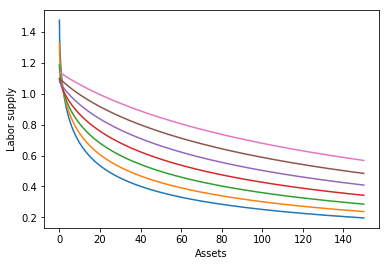

In [5]:
ss = hank_ss()
plt.plot(ss['a_grid'], ss['n'].T)
plt.xlabel('Assets'), plt.ylabel('Labor supply')
plt.show()

### Checking Walras's law
It's always a good idea to check whether Walras's law holds. The omitted goods market clearing condition reads simply as 
$$
Y = C
$$
(there are no price-adjustment costs in the zero-inflation steady state) and is reported by the `hank_ss` function above.

In [6]:
print(ss['goods_mkt'])

-5.258183666256855e-09


<a id="3-jacobian"></a>

## 3 Jacobians
Jacobians are the key concept to solve and to estimate models in sequence space. Each model block has its own Jacobians which can be combined via the chain rule into Jacobians of full model. A Jacobian in a $T$-dimensional (truncated) sequence space is a $T \times T$ matrix of the form

$$
\frac{d Y}{d X} = 
\begin{pmatrix}
\frac{d Y_0}{d X_0} & \frac{d Y_0}{d X_1} & \dots & \frac{d Y_0}{d X_T} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{d Y_T}{d X_0} & \frac{d Y_T}{d X_1} & \dots & \frac{d Y_T}{d X_T}
\end{pmatrix}
$$

evaluated at the steady state.

### 3.1 Simple blocks
To build intuition, let's start with the firm block. In our code, simple blocks are specified as regular Python functions  endowed with the decorator ``@simple``. In the body of the function, we directly implement the corresponding equilibrium conditions. The decorator turns the function into an instance of ``SimpleBlock``, a simple class with methods to evaluate itself in steady state and along a transition path. Notice the use of K(-1) to denote 1-period lag, similarly to Dynare. In general, one can write (-s) and (+s) to denote s-period lags and leads.

The DAG above has 6 simple nodes. But it makes sense to consolidate all market clearing conditions in a single block. This leaves us with the following five blocks.

In [7]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y
    return L, Div

@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r

@simple
def fiscal(r, B):
    Tax = r * B
    return Tax

@simple
def mkt_clearing(A, NS, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NS - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * np.log(1 + pi(+1)) / (1 + r(+1)) - np.log(1 + pi)
    return nkpc_res

Let's take a look at the Jacobians of the Phillips curve.

In [8]:
J_nkpc = nkpc.jac(ss, T=5, shock_list=['pi', 'w', 'Z', 'Y', 'r'])
print(J_nkpc['nkpc_res']['pi'])
print(J_nkpc['nkpc_res'].keys())

[[-1.          0.99502488  0.          0.          0.        ]
 [ 0.         -1.          0.99502488  0.          0.        ]
 [ 0.          0.         -1.          0.99502488  0.        ]
 [ 0.          0.          0.         -1.          0.99502488]
 [ 0.          0.          0.          0.         -1.        ]]
dict_keys(['pi', 'w', 'Z'])


Notice two things. First, inflation shows up with a lead as well as contemporaneously, so the corresponsing Jacobian is not diagonal, though still sparse. Second, ``J_nkpc`` does not have entries for $(Y, r)$ even though we asked for them. The reason is they have no first-order effect, i.e. their Jacobians are zero. ``simple_block.jac`` recognizes this and does return them. This behavior ensures that we won't inadvertently do wasteful computations.   

### 3.2 HA blocks
The Jacobians of HA blocks are analogous objects to the Jacobians of simple blocks we just saw. They are $T \times T$ matrices linking aggregate inputs to aggregate outputs. We propose an efficient **fake news algorithm** to compute them. Please see the paper and the `het_jacobian.ipynb` notebook for details. 

The tools for dealing with Jacobians of HA blocks are in `het_block.py`. At the end of the day, we'll be able to use a method analogous to `SimpleBlock.jac` above. A notable difference is that the shocked inputs are specified as a nested dict. This may look like an unnecessarily complicated formulation, but it allows us to use the same, concise ``hank.backward_iterate`` function in any macro model. From the households' perspective, all that matters is what $(r, w, T)$ are. They just take this given, irrespective of how they are determined in the GE. 

So we proceed in two steps. First, compute the derivative of the state-specific transfer income with respect to aggregate dividends and taxes. Second, call ``HetBlock.jac`` method that we used for Krusell-Smith model as well. 

In [9]:
J_ha = household.jac(ss=ss, T=5, shock_list=['r','w', 'Div', 'Tax'])
print(J_ha['A']['Div'])

[[ 0.87384152 -0.03953207 -0.03629228 -0.03377711 -0.03159259]
 [ 0.83866702  0.83879767 -0.07305469 -0.06797912 -0.06363951]
 [ 0.80656573  0.80634824  0.80781669 -0.10274882 -0.09619012]
 [ 0.77665669  0.77633992  0.77737032  0.7799925  -0.1293818 ]
 [ 0.74865364  0.74815697  0.74901704  0.75113206  0.75483886]]


<a id="4-linear"></a>

## 4 Linearized dynamics using Jacobians
Recall that we reduced the to the following DAG:

![Directed Acyclical Graph](figures/hank_dag.png) 

that can also be written as an implicit equation

$$
H(\pi, Y, w; r^*, Z) =
\begin{pmatrix}
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{L}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0\end{pmatrix},
$$

to be solved for $U=(\pi, w, Y)$ given any $Z=(Z, r^*)$. The rest of the endogenous variables are be obtained as explicit functions of $(\pi, w, Y; Z, r^*)$ along the DAG, but it would be tedious to write them out.

Keep in mind that the implicit function theorem implies that the response of unknowns

$$
dU = \underbrace{-H_U^{-1}H_Z}_{G} dZ \tag{1}
$$

Then the response of other endogenous variables, e.g. consumption, can be computed as the sum of direct and indirect effects:

$$
dC = \underbrace{\frac{\partial C}{\partial r^*} d r^* + \frac{\partial C}{\partial Z} dZ}_{\text{direct}} + \underbrace{\frac{dC}{dU} dU}_{\text{indirect}}. \tag{2}
$$

Recall that we already solved for a steady state and stored is as `ss`. Furthermore, we will use a 300-period truncation horizon. 

### 4.1 Convenient approach

The surest way to obtain the general equilibrium Jacobians is to precompute the Jacobian of the HA block(s), then call the `get_G` convenience function.

In [10]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# jacobian of HA block
#J_ha = household.jac(ss=ss, T=T, shock_list=['r','w','Div','Tax'])

# general equilibrium jacobians
#block_list = [firm, monetary, fiscal, nkpc, mkt_clearing, J_ha]
block_list = [firm, monetary, fiscal, nkpc, mkt_clearing, household]
G = jac.get_G(block_list, exogenous, unknowns, targets, T, ss, save=True)

### 4.2 Breaking down `get_G`

#### Step 1: Topological sort and partial Jacobians
By looking at the inputs and outputs of each block, we can sort them in a correct (not necessarily unique) order along the DAG. Knowing the DAG is a prerequisite for all that follows, and also allows us to avoid wasteful Jacobian calculations: we only need Jacobians with respect to unknowns, exogenous, and outputs of earlier blocks.

In [11]:
curlyJs, required = jac.curlyJ_sorted(block_list, unknowns+exogenous, ss, T)

The first output `curlyJs` is a list of nested dictionaries. Each element of the list contain all the necessary Jacobians for the corresponding block. The order of blocks is as in the DAG. 

For example, the first block is `monetary`, because it only takes an unknown $\pi$ and an exogenous $r^*$ as inputs. Let's take a look. 

In [12]:
print(curlyJs[0])

{'r': {'pi': SimpleSparse({(0, 0): -1.005, (-1, 0): 1.500}), 'rstar': SimpleSparse({(-1, 0): 1.000})}}


Since this is a simple block, the Jacobians are represented as a instances of the `SimpleSparse` class. Note that `jac.curlyJ_sorted` correctly determined that it is not necessary to differentiate with respect to the Taylor rule parameter $\phi$ (if we wanted to consider shocks to this parameter, we'd just have to include it among the exogenous inputs.)

The second output `required` is a set of extra variables (not unknowns and exogenous) that we have to differentiate with respect to, because they are outputs of some blocks and inputs of others. 

In [13]:
print(required)

{'NS', 'L', 'Div', 'C', 'Tax', 'A', 'r'}


#### Step 2: Compose Jacobians along the DAG
We're interested in the Jacobians with respect to the inputs of $H$, that means the unknowns $(\pi, w, Y)$ and the shocks $(r^*, Z).$  

First, we apply the chain rule by using `jac.forward_accumulate`. This gives the $T \times T$ building blocks of the $H_U$ and $H_Z$ that relate targets to unknowns and exogenous. 

In [14]:
J_curlyH_U = jac.forward_accumulate(curlyJs, unknowns, targets, required)
J_curlyH_Z = jac.forward_accumulate(curlyJs, exogenous, targets, required)
print(J_curlyH_U.keys())
print(J_curlyH_U['asset_mkt'].keys())

dict_keys(['nkpc_res', 'asset_mkt', 'labor_mkt'])
dict_keys(['Y', 'w', 'pi'])


Next, we just have to pack them into two (big) matrices. These capture (to first order) the implicit relationship between unknowns $X=(\pi, w, Y)$ induced by the requirement that markets clear and the Phillips curve holds, i.e. that the targets of the DAG evaluate to zero.

In [15]:
H_U = jac.pack_jacobians(J_curlyH_U, unknowns, targets, T)
H_Z = jac.pack_jacobians(J_curlyH_Z, exogenous, targets, T)
print(H_U.shape)
print(H_Z.shape)

(900, 900)
(900, 600)


#### Step 3: General equilibrium Jacobians
First we can get the response of unknowns directly by the implicit function theorem.

In [16]:
G_U = jac.unpack_jacobians(-np.linalg.solve(H_U, H_Z), exogenous, unknowns, T)
print(G_U.keys())

dict_keys(['pi', 'w', 'Y'])


And the rest can be obtained by forward accumulation that accounts for the direct and indirect effects alike.

In [17]:
curlyJs = [G_U] + curlyJs
outputs = set().union(*(curlyJ.keys() for curlyJ in curlyJs)) - set(targets)

G2 = jac.forward_accumulate(curlyJs, exogenous, outputs, required | set(unknowns))

### 4.3 Results
First let's check that the two approaches give the same answer.

In [18]:
for o in G.keys():
    for i in G[o].keys():
        assert np.allclose(G[o][i], G2[o][i])

Now let's consider 25 basis point monetary policy shocks with different persistences and plot the response of inflation.

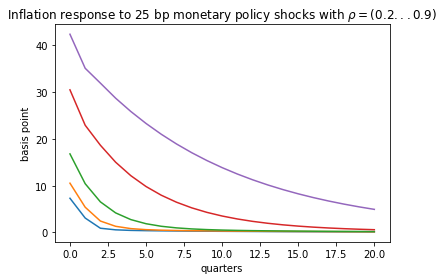

In [19]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar
plt.plot(10000 * dpi[:21])
plt.title(r'Inflation response to 25 bp monetary policy shocks with $\rho=(0.2 ... 0.9)$')
plt.xlabel('quarters'); plt.ylabel('basis point')
plt.show()

<a id="5-nonlinear"></a>

## 5. Nonlinear dynamics
Conceptually there's nothing new in this section compared to the Krusell-Smith notebook. We're going to implement a quasi-Newton algorithm to solve for the unknown sequences $U=(\pi, w, Y)$ given some sequences of shocks $(r^*, Z).$ We initialize the algorithm by the naive guess that the variables in $U$ stay constant at their steady-state level. Then we evaluate the DAG and update the guess using the inverse Jacobian $H_U^{-1}.$ The algorithm converges in a few steps, despite the presence of substantial nonlinearities.

In [20]:
def td_map(ss, **kwargs):
    # initialize results
    results = kwargs

    # blocks before HA
    for b in [firm, monetary, fiscal]:
        results.update(b.td(ss, **{k: results[k] for k in b.inputs if k in results}))

    # hetinput
    results['div'] = results['Div'][:, np.newaxis] / np.sum(ss['pi_s'] * ss['div_rule']) * ss['div_rule']
    results['tax'] = results['Tax'][:, np.newaxis] / np.sum(ss['pi_s'] * ss['tax_rule']) * ss['tax_rule']

    # HA block
    results.update(household.td(ss, monotonic=True, T=results['div']-results['tax'],
                                **{k: results[k] for k in household.inputs if k in results}))

    # blocks after HA
    for b in [nkpc, mkt_clearing]:
        results.update(b.td(ss, **{k: results[k] for k in b.inputs if k in results}))

    return results

### 5.1 A typical monetary policy shock
Note that the linearized solution ignores price adjustment costs. For a monetary policy shock of typical size and persistent, this does not really matter.   

In [21]:
rho_r, sig_r = 0.61, -0.01/4
drstar = sig_r * rho_r ** (np.arange(T))
rstar = ss['r'] + drstar

H_U = jac.get_H_U(block_list, unknowns, targets, T, ss, use_saved=True)
H_U_factored = utils.factor(H_U)

td_nonlin = nonlinear.td_solve(ss, block_list, unknowns, targets, H_U_factored=H_U_factored, 
                               rstar=rstar)

On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 1.46E-02
   max error for labor_mkt is 2.73E-03
On iteration 1
   max error for nkpc_res is 1.16E-06
   max error for asset_mkt is 1.33E-04
   max error for labor_mkt is 6.89E-06
On iteration 2
   max error for nkpc_res is 4.81E-08
   max error for asset_mkt is 2.21E-06
   max error for labor_mkt is 1.42E-07
On iteration 3
   max error for nkpc_res is 1.26E-09
   max error for asset_mkt is 3.46E-08
   max error for labor_mkt is 8.41E-10
On iteration 4
   max error for nkpc_res is 2.10E-11
   max error for asset_mkt is 5.01E-10
   max error for labor_mkt is 1.26E-11


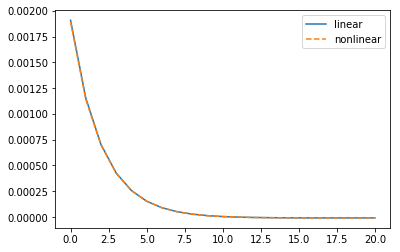

In [22]:
dC_nonlin = td_nonlin['C'] - ss['C']
dC_lin = G['C']['rstar'] @ drstar

plt.plot(dC_lin[:21], label='linear', linestyle='-')
plt.plot(td_nonlin['C'][:21]-ss['C'], label='nonlinear', linestyle='--')
plt.legend()
plt.show()

### 5.2 A large monetary policy shock
However, the nonlinearities may become substantial for large or persistent monetary policy shocks. Reassuringly, the Jacobian still works well as an updating rule. The quasi-Newton method still converges in just 7 iterations.

On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 7.19E-02
   max error for labor_mkt is 1.36E-02
On iteration 1
   max error for nkpc_res is 2.72E-05
   max error for asset_mkt is 3.28E-03
   max error for labor_mkt is 1.59E-04
On iteration 2
   max error for nkpc_res is 3.40E-06
   max error for asset_mkt is 2.74E-04
   max error for labor_mkt is 1.32E-04
On iteration 3
   max error for nkpc_res is 2.53E-07
   max error for asset_mkt is 2.50E-05
   max error for labor_mkt is 6.01E-06
On iteration 4
   max error for nkpc_res is 6.99E-08
   max error for asset_mkt is 2.08E-06
   max error for labor_mkt is 9.69E-07
On iteration 5
   max error for nkpc_res is 5.79E-09
   max error for asset_mkt is 3.03E-07
   max error for labor_mkt is 1.37E-07
On iteration 6
   max error for nkpc_res is 7.24E-10
   max error for asset_mkt is 1.67E-08
   max error for labor_mkt is 1.41E-08
On iteration 7
   max error for nkpc_res is 9.67E-11
   max error for asset_mkt is 

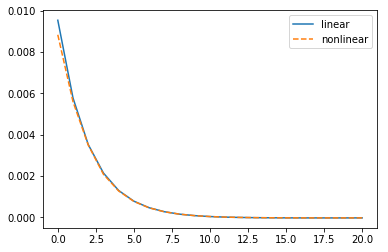

In [23]:
rho_r, sig_r = 0.61, -0.05/4
drstar = sig_r * rho_r ** (np.arange(T))
rstar = ss['r'] + drstar

td_nonlin = nonlinear.td_solve(ss, block_list, unknowns, targets, H_U_factored=H_U_factored, 
                               rstar=rstar)

dC_nonlin = td_nonlin['C'] - ss['C']
dC_lin = G['C']['rstar'] @ drstar

plt.plot(dC_lin[:21], label='linear', linestyle='-')
plt.plot(td_nonlin['C'][:21]-ss['C'], label='nonlinear', linestyle='--')
plt.legend()
plt.show()

<a id="6-determinacy"></a>

## 6. Local determinacy
Local determinacy boils down to the invertibility of the matrix $H_U.$ The steady state is a locally-stable equilibrium if and only if $H_X$ is invertible. In practice, $H_U$ is obtained numerically for a finite horizon, and thus we can never expect it to be exactly singular. Still, near-singularity of $H_U$ that gets worse with increasing the horizon $T$ is a clear indication of indeterminacy. 

As it is well-known, determinacy in the New Keynesian models requires that the interest rate rule is sufficiently responsive to inflation. Therefore, we're going to illustrate the issue by varying the parameter $\phi$ and trace its effect on $H_U.$

### 6.1 Stable case
Let's start with the the baseline calibration with $\phi=1.5$.

In [24]:
# condition number
cond = np.linalg.cond(H_U)
print(f'Condition number: {cond:.2f}')

# smallest singular value
_, s, _ = np.linalg.svd(H_U)
print(f'Smallest singular value: {s[-1]:.2f}')

Condition number: 4354.18
Smallest singular value: 0.07


### 6.2 Unstable case
Let's see what happens with $\phi=0.75$. First of all, we'll have to recompute the Jacobian. It's important to realize that $\phi$ does not affect the steady state, and affects dynamics only through the monetary block. Thus, recomputing the Jacobians of any other block, especially the heterogeneous household block, would be wasteful.

In [25]:
import copy
ss2 = copy.deepcopy(ss)
ss2['phi'] = 0.75 

H_U2 = jac.get_H_U(block_list, unknowns, targets, T, ss2)

This time the condition number and smallest singular value both clearly indicate indeterminacy.

In [26]:
# condition number
cond2 = np.linalg.cond(H_U2)
print(f'Condition number: {cond2:.2f}')

# smallest singular value
_, s2, _ = np.linalg.svd(H_U2)
print(f'Smallest singular value: {s2[-1]:.6f}')

Condition number: 185538900429.60
Smallest singular value: 0.000000


Not surprisingly, if we tried to use this Jacobian to compute impulse responses, we'd fail. (We'll wrap in a try/except block to avoid a giant error message.)

In [27]:
try:
    td_nonlin = nonlinear.td_solve(ss2, block_list, unknowns, targets, H_U=H_U2, 
                                   rstar=rstar)
except ValueError as e:
    print(e)

On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 7.19E-02
   max error for labor_mkt is 1.36E-02
Cannot solve constrained household's problem: No convergence after 30 iterations!


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In fact, it fails after the first iteration: since the Jacobian is nearly singular, using its inverse in Newton's method leads to a very large step to the next guess, which then is outside the admissible domain and leads to an error within the household routine.

### Test to see if it works?

In [28]:
import determinacy as det

In [29]:
A = jac.get_H_U(block_list, unknowns, targets, T, ss, asymptotic=True, save=True, use_saved=True)

In [30]:
det.winding_criterion(A)

0

In [31]:
A = jac.get_H_U(block_list, unknowns, targets, T, ss2, asymptotic=True)

In [32]:
det.winding_criterion(A)

-1

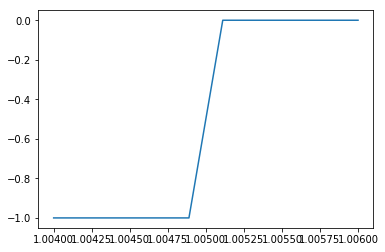

In [33]:
phis = np.linspace(1.004, 1.006, 10)
windings = np.empty_like(phis)
for i, phi in enumerate(phis):
    ss_cur = {**ss, 'phi': phi}
    A = jac.get_H_U(block_list, unknowns, targets, T, ss_cur, asymptotic=True, use_saved=True)
    windings[i] = det.winding_criterion(A)
plt.plot(phis, windings)

**Go back to determinate A**

In [34]:
A = jac.get_H_U(block_list, unknowns, targets, T, ss, asymptotic=True, use_saved=True)

In [35]:
import asymptotic

Unpack this...

In [36]:
HU_unpacked = {}
for o, t in enumerate(targets):
    HU_unpacked[t] = {}
    for i, u in enumerate(unknowns):
        HU_unpacked[t][u] = asymptotic.AsymptoticTimeInvariant(A[:, o, i])

Now feed it to asymptotic's stack_invert.

In [37]:
Tpost=2*T
tau = Tpost

In [38]:
%time U_H_unpacked_asym = asymptotic.invert_jacdict(HU_unpacked, unknowns, targets, tau)

CPU times: user 3.56 ms, sys: 510 µs, total: 4.07 ms
Wall time: 4.25 ms


In [39]:
U_H = np.linalg.inv(jac.get_H_U(block_list, unknowns, targets, T, ss, use_saved=True))
U_H_unpacked = jac.unpack_jacobians(U_H, targets, unknowns, T)

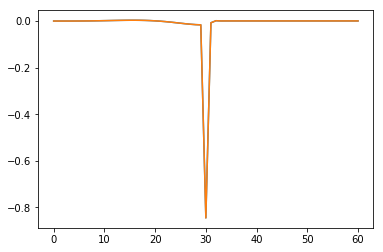

In [40]:
plt.plot(U_H_unpacked['Y']['labor_mkt'][150-30:150+31, 150])
plt.plot(U_H_unpacked_asym['Y']['labor_mkt'][-30:31])